# Landau Damping - Extended

Text adapted from [1]: *While fast sheets are able to excite an electrostatic wake in their rear, the resulting electrostatic wake can also accelerate sheets moving slightly slower than its phase velocity [2, 3].
Electrostatic modes are therefore self-consistently generated by particles moving close to its phase velocity, while being damped by particles moving slightly slower. However, since a plasma in thermal equilibrium follows a Maxwellian distribution in velocity space, there exist on average more particles moving faster than the wave, than those moving slower. Therefore, on average, the modes will be damped. This mechanism is known as Landau damping [3] and is an inherently collisionless kinetic process that the sheet model has been shown to recover [2]*. <br>
    *For a given mode $m$, with a wavelength $\lambda_m = 2L/m$ and wave vector $k_m = 2\pi/\lambda_m$, we can compute its wave frequency and damping time by finding numerically the roots of the dispersion relation for $k=k_m$* [2]:

\begin{equation}
    1 = \frac{\omega_p^2}{k^2} \int^\infty_{-\infty} \frac{\partial \hat{f}_0/\partial v}{v - (\omega/k)} dv
\end{equation}

*where $\hat{f}_0$ corresponds to the distribution function in velocity space. The solution will have both a real and imaginary part. The real part corresponds to the wave angular frequency, while the imaginary part corresponds to the inverse of the damping time.*

In this notebook we demonstrate that modes are indeed self-consistently generated and damped in accordance with the predicted decay time when doing simulations with the GNS. We will perform a scan over a significant amount of mode wavelengths and initial amplitudes in order to compare with the theoretical curves.

**Note**: This notebook takes a long time to run (>2h30) due to the large amount of long simulations and generates ~1GB of output files. For a lighter version we recommend seeing [Landau_Damping.ipynb](Landau_Damping.ipynb)

#### References
[1] D. Carvalho et al., arXiv:2310.17646 (2023) - See Section 6.4 and 6.6 <br>
[2] J. Dawson, Phys. Fluids 5.4 (1962) - See pp. 450 <br>
[3] F. Chen, Introduction to Plasma Physics and Controlled Fusion Vol. 1 (1984) - See Chapter 7 <br>
[4] J. Jackson, Journal of Nuclear Energy. Part C, Plasma Physics, Accelerators, Thermonuclear
Research 1 171 (1960)

In [1]:
import os
import jax
import sys
import pickle
import numpy as np

from pathlib import Path
from tqdm.auto import tqdm
from scipy.stats import linregress

# uncomment the line below for nicer plots (needs LaTeX)
# os.environ['MATPLOTLIBRC'] = '../matplotlibrc'
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sys.path.append('../..')
from gns.simulator import SMGNS
from sheet_model.utils import get_x_eq, get_dx_eq, get_mode_info, get_mode_evolution, \
                              get_relaxation_time

## dont let JAX preallocate all GPU memory + free unused arrays 
## https://jax.readthedocs.io/en/latest/gpu_memory_allocation.html
## makes code slower
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false" 
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

## System Parameters

In [2]:
# system properties
n_sheets = 10000
t_max = 500
boundary = 'reflecting' 

dx_eq = get_dx_eq(n_sheets) 
x_eq = get_x_eq(n_sheets)

v_th = 5 # [dx_eq w_p]
v_std_0 = 5.2 # slightly higher value to initialize sheet velocities

t_relax = get_relaxation_time(v_std_0)


# GNS
model_folder = Path(f'../../models/final/dt1e-1/4/')
gns = SMGNS(model_folder, boundary, verbose=False)

## Pick modes to follow

In [3]:
# modes that will be followed
# if v_ph > 3 v_th, almost no particles will exist to resonate with the wave
# if v_ph ~ 2 v_th, one is too close to plasma bulk (and mode decays very fast)
MODES = np.arange(180, 450, 2)
for mode in MODES:
    mode_info = get_mode_info(mode, n_sheets=n_sheets, v_th=v_th, num=True)
    print(f'Mode: {mode}')
    print(f'lambda: {mode_info["lambda"]:0.1f} [dx_eq]')
    print(f'v_ph/v_th: {mode_info["v_ph"]/v_th:0.1f}')
    print(f'w/w_p: {mode_info["w"]:0.2f}')
    print(f'1/gamma', 1/mode_info["gamma"], '[w_p^-1]')
    print(f'k*lambda_D: {mode_info["k"]*v_th:.2f}')
    print()

Mode: 180
lambda: 111.1 [dx_eq]
v_ph/v_th: 4.0
w/w_p: 1.14
1/gamma -128.9263323579592 [w_p^-1]
k*lambda_D: 0.28

Mode: 182
lambda: 109.9 [dx_eq]
v_ph/v_th: 4.0
w/w_p: 1.14
1/gamma -117.10314652722236 [w_p^-1]
k*lambda_D: 0.29

Mode: 184
lambda: 108.7 [dx_eq]
v_ph/v_th: 4.0
w/w_p: 1.15
1/gamma -106.74631170282501 [w_p^-1]
k*lambda_D: 0.29

Mode: 186
lambda: 107.5 [dx_eq]
v_ph/v_th: 3.9
w/w_p: 1.15
1/gamma -97.63591613196523 [w_p^-1]
k*lambda_D: 0.29

Mode: 188
lambda: 106.4 [dx_eq]
v_ph/v_th: 3.9
w/w_p: 1.15
1/gamma -89.58992286653731 [w_p^-1]
k*lambda_D: 0.30

Mode: 190
lambda: 105.3 [dx_eq]
v_ph/v_th: 3.9
w/w_p: 1.16
1/gamma -82.4569000212594 [w_p^-1]
k*lambda_D: 0.30

Mode: 192
lambda: 104.2 [dx_eq]
v_ph/v_th: 3.9
w/w_p: 1.16
1/gamma -76.11027593055114 [w_p^-1]
k*lambda_D: 0.30

Mode: 194
lambda: 103.1 [dx_eq]
v_ph/v_th: 3.8
w/w_p: 1.17
1/gamma -70.4437744335127 [w_p^-1]
k*lambda_D: 0.30

Mode: 196
lambda: 102.0 [dx_eq]
v_ph/v_th: 3.8
w/w_p: 1.17
1/gamma -65.3677686850904 [w_p^-1]
k*

In [15]:
def get_i_track(A, dA, r, dr, di, n_skip=0):
    """
    Return list of array indices (time) where to start tracking mode trajectory since its 
    amplitude became close to the defined threshold value.
    
    Args:
        A - mode amplitude (#timesteps)
        dAm - mode amplitude rate of change (#timesteps)
        r - threshold value
        dr - allowed range around threshold (abs(sqrt(A**2 + dAm**2)) - r) < dr)
        di - desired length of trajectory (avoid duplicate trajectories)
        n_skip - number of indices to skip (initialization of fields is not "clean")
        
    Returns:
        i_start
    """
    
    i_start = np.squeeze(np.argwhere(np.abs(np.sqrt(A**2 + dA**2) - r) < dr))
    # remove indices that do not provide full trajectory
    i_start = i_start[i_start + di < len(A)]
    # remove indices below n_skip
    i_start = i_start[i_start > n_skip]
    
    if i_start.size != 0:
        i_no_duplicates = [i_start[0]]
        for i in i_start:
            # only add if beginning of new trajectory is not included
            # in previous interval
            if i - i_no_duplicates[-1] > di:
                i_no_duplicates.append(i)
        

        i_start = np.array(i_no_duplicates, dtype=np.int64)

        return i_start

## Run Simulations

In [5]:
# perform several simulations (takes some time)
N_SIM = 100
np.random.seed(42)

M_N_Am = {m:[] for m in MODES} # stores amplitudes (mode, #simulations, #timesteps)
M_N_dAm = {m:[] for m in MODES} # stores amplitude rate of change (mode, #simulations, #timesteps)

for n in tqdm(range(N_SIM)):
    
    x0 = x_eq
    v0 = np.random.normal(0, v_std_0, n_sheets) * dx_eq

    X, V, X_eq, E = gns.pred_rollout(x0, 
                                  v0,
                                  x_eq,
                                  dt=gns.dt_train,
                                  t_max=t_max,
                                  n_guards=5,
                                  verbose=False,
                                  track_sheets=False,
                                  np_=np)

    if boundary == 'periodic':
        # for periodic boundary have to force 
        # equilibrium positions to be inside the box
        # and sort sheets accordingly for correct mode amplitude calculation
        aux = X_eq // 1
        X -= aux
        X_eq -= aux
        i_sort = np.argsort(X_eq, axis=-1)
        X = np.take_along_axis(X, i_sort, -1)
    
    if n == 0:
        # just to check if simulator is behaving well
        print(f'dE/E0: {np.mean(E[-int(2*np.pi/gns.dt_train):]-E[0])/E[0]}')
    
    for m in MODES:
        Am, dAm = get_mode_evolution(m, X, x_eq, gns.dt_train)
        M_N_Am[m].append(Am)
        M_N_dAm[m].append(dAm)
    
    ## save results 
    ## useful to store since simulation take a long time to run
    with open('ld_Am_Large.pkl', 'wb') as f:
        pickle.dump(M_N_Am, f)

    with open('ld_dAm_Large.pkl', 'wb') as f:
        pickle.dump(M_N_dAm, f)

for m in MODES:
    M_N_Am[m] = np.array(M_N_Am[m])
    M_N_dAm[m] = np.array(M_N_dAm[m])

  0%|          | 0/100 [00:00<?, ?it/s]

dE/E0: 0.004625186324119568


## (Optional) Load / Save files

In [99]:
## save results 
## useful to store since simulation take a long time to run
with open('ld_Am_Large.pkl', 'wb') as f:
    pickle.dump(M_N_Am, f)

with open('ld_dAm_Large.pkl', 'wb') as f:
    pickle.dump(M_N_dAm, f)

In [4]:
## load results 
## useful to store since simulation take a long time to run
with open('ld_Am_Large.pkl', 'rb') as f:
    M_N_Am = pickle.load(f)

with open('ld_dAm_Large.pkl', 'rb') as f:
    M_N_dAm = pickle.load(f)

## Examples of mode amplitude evolution for a single simulation

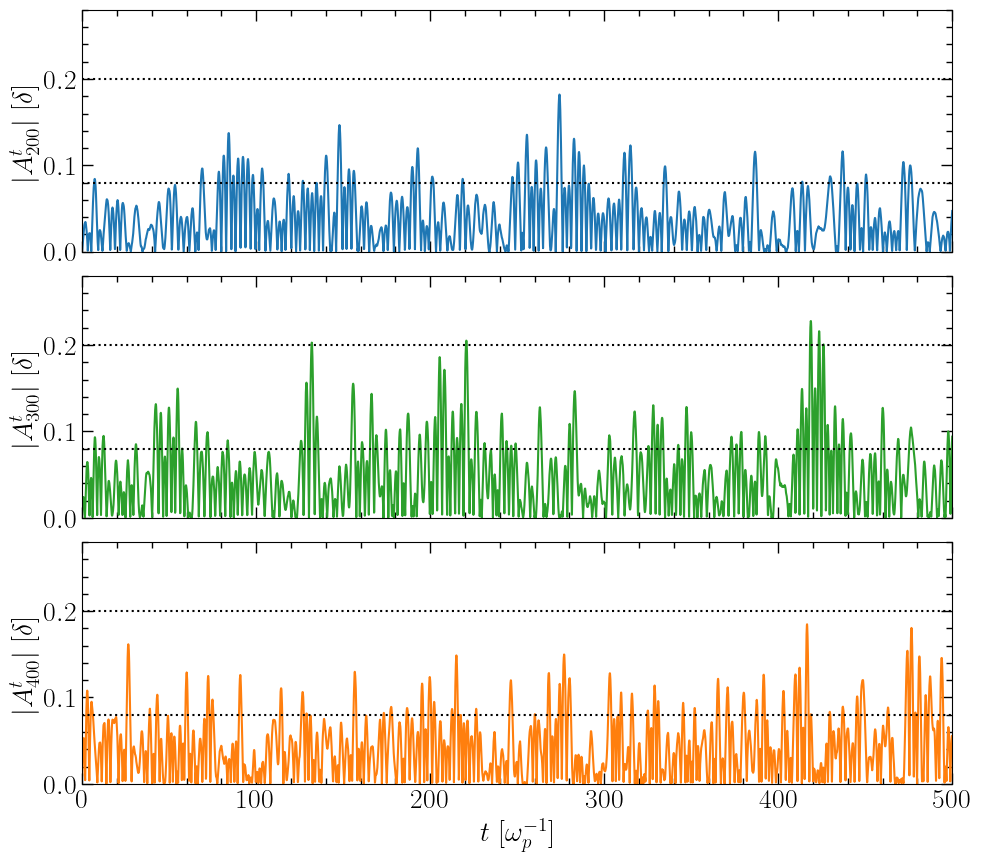

In [7]:
# examples of mode evolution
m = [200, 300, 400]
colors = ['tab:blue', 'tab:green', 'tab:orange']
fig, ax = plt.subplots(len(m), 1, figsize=(10, 3*len(m)), sharex=True, sharey=True,
                       gridspec_kw={'hspace':0.1, 'top': 0.97, 'right':0.97, 'left': 0.1})
for i, mi in enumerate(m):
    ax[i].plot(np.linspace(0, t_max, len(M_N_Am[mi][0])),
               np.abs(M_N_Am[mi][0]) / dx_eq, 
               color=colors[i])
    ax[i].axhline(0.08, color='k', ls=':')
    ax[i].axhline(0.2, color='k', ls=':')
    ax[i].set_ylabel(f'$|A_{{{m[i]}}}^t| [\delta]$')

ax[0].set_xlim(0, t_max)
ax[0].set_ylim(0, 0.28)

ax[-1].set_xlabel('$t [\omega_p^{-1}]$')
plt.savefig('../img/ld_mode_evolution_ex.pdf')
plt.show()

## Examples of average mode trajectory in ($A_m$, $\dot{A}_m$) phase-space

#tracks 518
#tracks 606
#tracks 645


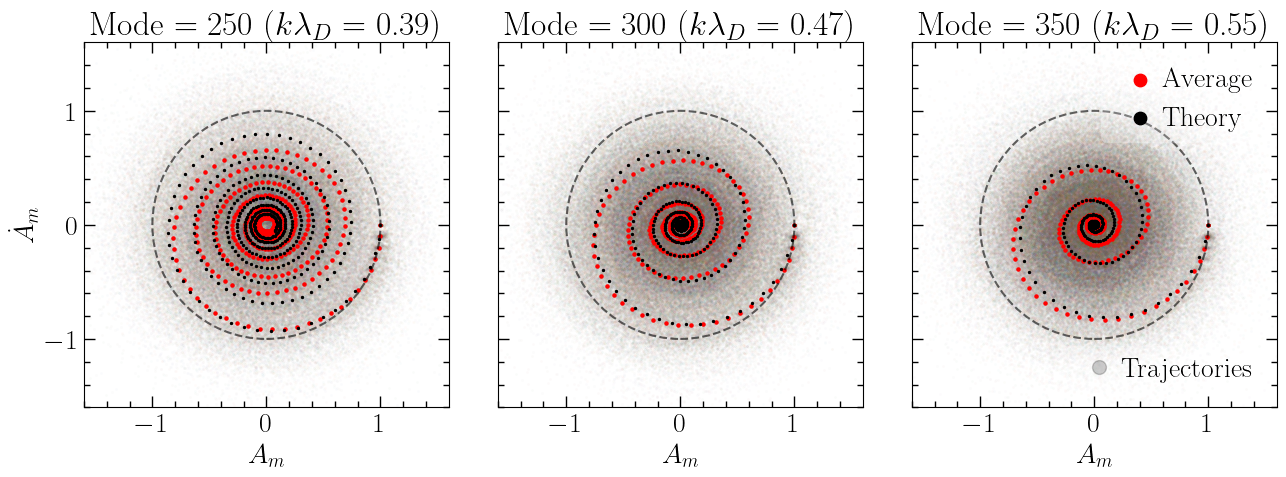

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(13, 5), 
                       gridspec_kw={'wspace':0.05, 'left':0.05, 'right':0.99, 'bottom':0.15}, 
                       sharey=True, sharex=True)


for im, mode in enumerate([250, 300, 350]):
    
    N_Am = M_N_Am[mode]
    N_dAm = M_N_dAm[mode]
    
    R = 0.15 * dx_eq
    dR = R * 0.01
    di = int(40/gns.dt_train)
    t = np.arange(di) * gns.dt_train
    
    n_tracks = 0
    rotated = []
    mode_info = get_mode_info(mode, n_sheets=n_sheets, v_th=v_th, num=True)

    for Am, dAm in zip(N_Am, N_dAm):
    
        i_track = get_i_track(Am, dAm, R, dR, di, n_skip=14/gns.dt_train)
        
        if not i_track is None:
                
            n_tracks += len(i_track)
                
            for i in i_track:

                theta = -np.arctan(dAm[i]/Am[i])
                if Am[i] < 0:
                    theta += np.pi

                # Create the 2x2 rotation matrix
                rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                            [np.sin(theta), np.cos(theta)]])

                # Apply the rotation matrix to the vector
                rotated_vector = np.dot(rotation_matrix, np.vstack([Am[i:i+di], dAm[i:i+di]]))

                rotated.append(rotated_vector)
                ax[im].scatter(*rotated_vector/R, s=2, alpha=0.01, rasterized=True)

    if n_tracks != 0:
        print('#tracks', n_tracks)
        
        rotated = np.array(rotated)
        avg = ax[im].scatter(*np.mean(np.array(rotated), axis=0)/R, 
                             color='r', s=5, label='Average')

        aux = np.exp(mode_info['gamma']*t)
        theory = ax[im].scatter(aux*np.cos(t*2*np.pi/(mode_info['lambda']/mode_info['v_ph'])),
                                -aux*np.sin(t*2*np.pi/(mode_info['lambda']/mode_info['v_ph'])), 
                                color='black', s=2, label='Theory')


        circle = plt.Circle((0, 0), 1, linestyle='--', color='k', fill=False, alpha=0.6, linewidth=1.5)
        ax[im].add_patch(circle)
        ax[im].set_title(f'Mode = {mode} ($k\lambda_D$ = {mode_info["k"]*v_th:.2f})')

        
plt.setp(ax[0], ylabel='$\dot{A}_m$')
plt.setp(ax, xlabel='$A_m$')
plt.setp(ax, xlim=[-1.6,1.6])
plt.setp(ax, ylim=[-1.6,1.6])
plt.setp(ax, aspect='equal')

trajectory = mlines.Line2D([], [], color='k', marker='o', linestyle='None',
                              markersize=10, label='Trajectories', alpha=0.2)
legend2 = plt.legend(handles=[trajectory], loc='lower right', framealpha=0.2, handletextpad=-0.2)
legend = plt.legend(handles=[avg, theory], loc='upper right', framealpha=0.2, handletextpad=-0.2)

for l in legend.legendHandles:
    l._sizes = [80]

ax[-1].add_artist(legend2)

plt.savefig(f'../img/ld_multiple_new.pdf')
plt.show()

## Examples of how to estimate damping rate + angular frequency

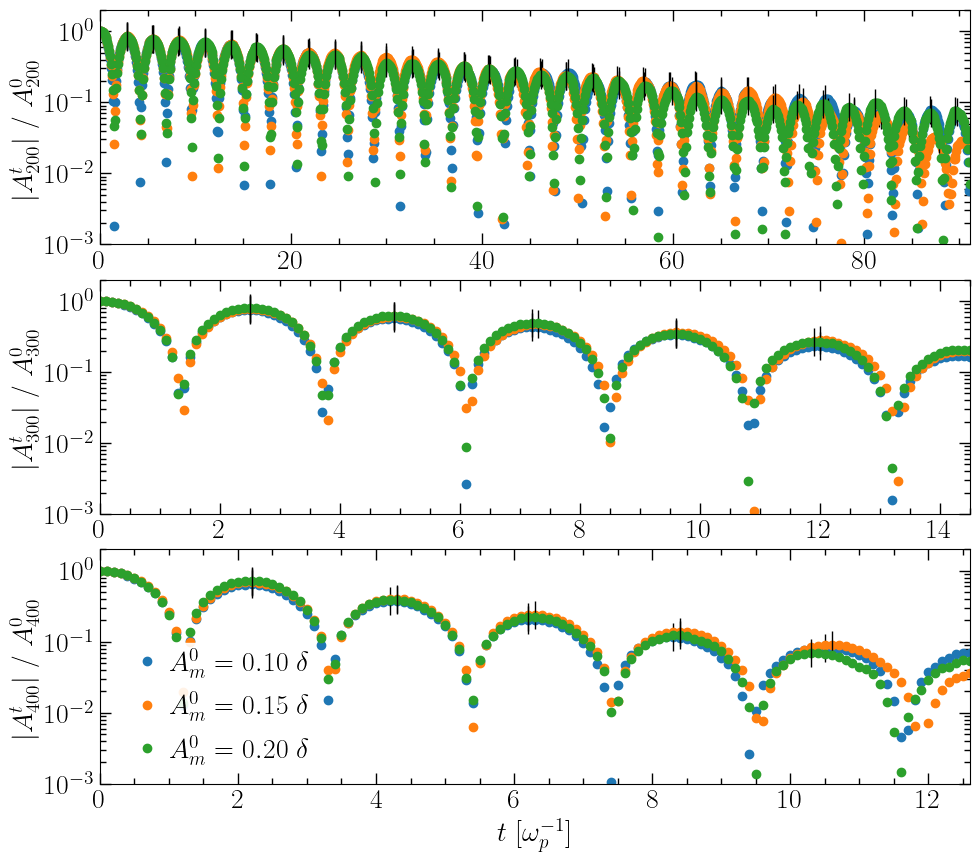

In [10]:
fig, ax = plt.subplots(len(m), 1, figsize=(10, 3*len(m)), sharex=False, sharey=True,
                       gridspec_kw={'hspace':0.15, 'top': 0.97, 'right':0.97, 'left': 0.1})


for im, mode in enumerate([200, 300, 400]):

    N_Am = M_N_Am[mode]
    N_dAm = M_N_dAm[mode]

    mode_info = get_mode_info(mode, n_sheets=n_sheets, v_th=v_th, num=True)

    amplitude_decay_ratio = 0.2
    
    # length of the trajectory (time)
    t_traj = np.log(amplitude_decay_ratio) / mode_info['gamma']
    t_traj = np.max([t_traj, 6 * np.pi / mode_info["w_approx"]])
    
    # length of trajectory (array indices)
    di = int(t_traj/gns.dt_train)
    di_pi = int(np.pi / gns.dt_train)

    t = np.arange(di) * gns.dt_train

    for Rd in np.arange(0.08, 0.205, 0.005):

        R = Rd * dx_eq
        dR = R * 0.01

        n_tracks = 0

        rotated = []
        
        # rotate all trajectories to start at (Am, dAm) = (R, 0)
        for Am, dAm in zip(N_Am, N_dAm):

            i_track = get_i_track(Am, dAm, R, dR, di, n_skip=14/gns.dt_train)

            if i_track is not None:

                n_tracks += len(i_track)

                for i in i_track:
                    # angle in phasespace where trajectory started
                    theta = -np.arctan(dAm[i]/Am[i])
                    if Am[i] < 0:
                        theta += np.pi

                    # create the 2x2 rotation matrix
                    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                                [np.sin(theta), np.cos(theta)]])

                    # apply the rotation matrix so trajectory starts at theta = 0
                    rotated_vector = np.dot(rotation_matrix, np.vstack([Am[i:i+di], dAm[i:i+di]]))

                    rotated.append(rotated_vector)

        
        # compute average amplitude + its maxima
        if n_tracks != 0:

            rotated = np.array(rotated)
            
            ## Get average Am trajectory
            R_Am = np.abs(np.mean(np.array(rotated), axis=0))[0] / R

            aux_t = t[di_pi//2:]
            aux_R = R_Am[di_pi//2:]

            period = (2*np.pi) / mode_info['w_approx'] / 2.
            di_period = int(period / gns.dt_train)

            ## Get maximum for every pi/w period
            ## skips first maximum because it contains contributions from ballistic modes (highly damped)
            i_max = [i*di_period + np.argmax(aux_R[i*di_period:(i+1)*di_period]) \
                      for i in range(len(aux_R)//di_period)]

            i_max = np.array(i_max)
            i_max = i_max[i_max < len(aux_R) - 3]
            
            ## Decay rate can be estimated from linear regression
            result = linregress(aux_t[i_max], np.log(aux_R[i_max]))
            ## Angular frequency from period of maxima
            w = np.pi / np.mean(np.diff(aux_t[i_max]))
          
            if Rd % 0.05 < 1e-8:
                ax[im].plot(t, R_Am, 'o', label=f'$A_m^0 = {Rd:.2f}~\delta$', rasterized=True)
                ax[im].plot(aux_t[i_max], aux_R[i_max], '|', markersize=20, linewidth=20, color='k')

        else:
            raise Exception(Rd)
        
    ax[im].set_xlim(0,t[-1])
    ax[im].set_ylabel(f'$|A_{{{mode}}}^t|$ / $A_{{{mode}}}^0$')


ax[-1].set_xlabel('$t$ [$\omega_p^{-1}$]')
ax[-1].set_yscale('log')
ax[-1].set_ylim(1e-3, 2e0)

legend = plt.legend(loc='lower left', framealpha=0.9, handletextpad=-0.2, borderpad=0.2)
plt.savefig('../img/ld_w_estimation_ex.pdf')
plt.show()

## Comparisons with theory

### Compute damping rates + angular frequency

In [12]:
# range of R values (initial mode amplitude)
RD = np.arange(0.08, 0.205, 0.005)

# buffers to store theoretical + measured values
Gamma_M_Am = {m: [] for m in MODES} # Im(w)
Gamma_M_Teor = {m: [] for m in MODES}
W_M_Am = {m: [] for m in MODES} # Re(w)
W_M_Teor = {m: [] for m in MODES}

# loop over modes
for mode in np.arange(180, MODES[-1], 2):
    
    N_Am = M_N_Am[mode]
    N_dAm = M_N_dAm[mode]

    mode_info = get_mode_info(mode, n_sheets=n_sheets, v_th=v_th, num=True)
    print(f'Mode: {mode}')
    print(f'lambda: {mode_info["lambda"]:0.1f} [dx_eq]')
    print(f'v_ph/v_th: {mode_info["v_ph"]/v_th:0.1f}')
    print(f'v_ph/v_th: {mode_info["v_ph_approx"]/v_th:0.1f}')
    print(f'w/w_p: {mode_info["w"]:0.2f}')
    print(f'1/gamma: {1/mode_info["gamma"]:.2f} [w_p^-1]')
    print(f'k*lambda_D: {mode_info["k"]*v_th:.2f}')
    print()


    ## uncomment if you want to plot decay examples
    #plt.figure()

    amplitude_decay_ratio = 0.2
    t_traj = np.log(amplitude_decay_ratio) / mode_info['gamma']
    t_traj = np.max([t_traj, 6 * np.pi / mode_info["w_approx"]])
    
    di = int(t_traj/gns.dt_train)
    di_pi = int(np.pi / gns.dt_train)

    t = np.arange(di) * gns.dt_train

    for Rd in RD:

        R = Rd * dx_eq
        dR = R * 0.01

        n_tracks = 0

        rotated = []

        for Am, dAm in zip(N_Am, N_dAm):

            i_track = get_i_track(Am, dAm, R, dR, di, n_skip=14/gns.dt_train)

            if i_track is not None:

                n_tracks += len(i_track)

                for i in i_track:
                    # angle in phasespace where trajectory started
                    theta = -np.arctan(dAm[i]/Am[i])
                    if Am[i] < 0:
                        theta += np.pi

                    # create the 2x2 rotation matrix
                    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                                [np.sin(theta), np.cos(theta)]])

                    # apply the rotation matrix so trajectory starts at theta = 0
                    rotated_vector = np.dot(rotation_matrix, np.vstack([Am[i:i+di], dAm[i:i+di]]))

                    rotated.append(rotated_vector)



        if n_tracks != 0:

            rotated = np.array(rotated)
            R_Am = np.abs(np.mean(np.array(rotated), axis=0))[0] / R
            
            aux_t = t[di_pi//2:]
            aux_R = R_Am[di_pi//2:]

            period = (2*np.pi) / mode_info['w_approx'] / 2.
            di_period = int(period / gns.dt_train)


            i_max = [i*di_period + np.argmax(aux_R[i*di_period:(i+1)*di_period]) \
                      for i in range(len(aux_R)//di_period)]

            i_max = np.array(i_max)
            i_max = i_max[i_max < len(aux_R) - 3]

            result = linregress(aux_t[i_max], np.log(aux_R[i_max]))
            Gamma_M_Am[mode].append(result.slope)
            Gamma_M_Teor[mode].append(mode_info['gamma'])

            w = np.pi / np.mean(np.diff(aux_t[i_max]))
            W_M_Teor[mode].append(mode_info['w'])
            W_M_Am[mode].append(w)

            ## uncomment if you want to plot
            #if Rd % 0.1 < 1e-8:
            #    print('#tracks', n_tracks)                    
            #    print(1/result.slope)
            #    plt.plot(t, R_Am, '.', label=f'R={Rd:.2f}')
            #    plt.plot(aux_t[i_max], aux_R[i_max], '*', color='k')

        else:
            raise Exception(f'No tracks found for R={Rd} and m={mode}.')
    
    ## uncomment if you want to plot
    #plt.plot(t, np.exp(mode_info['gamma']*t), c='k', label='Theory')
    #plt.plot(t, np.exp(mode_info['gamma_approx']*t), c='r', label='Theory Approx')
    #plt.xlabel('t [$\omega_p^{-1}$]')
    #plt.ylabel('$A_m^t$ / $A_m^0$')
    #plt.yscale('log')
    #plt.xlim(0,t[-1])
    #plt.ylim(1e-3, 2e0)
    #plt.legend()
    #plt.show()
    #plt.close()

Mode: 180
lambda: 111.1 [dx_eq]
v_ph/v_th: 4.0
v_ph/v_th: 3.9
w/w_p: 1.14
1/gamma: -128.93 [w_p^-1]
k*lambda_D: 0.28

Mode: 182
lambda: 109.9 [dx_eq]
v_ph/v_th: 4.0
v_ph/v_th: 3.9
w/w_p: 1.14
1/gamma: -117.10 [w_p^-1]
k*lambda_D: 0.29

Mode: 184
lambda: 108.7 [dx_eq]
v_ph/v_th: 4.0
v_ph/v_th: 3.9
w/w_p: 1.15
1/gamma: -106.75 [w_p^-1]
k*lambda_D: 0.29

Mode: 186
lambda: 107.5 [dx_eq]
v_ph/v_th: 3.9
v_ph/v_th: 3.8
w/w_p: 1.15
1/gamma: -97.64 [w_p^-1]
k*lambda_D: 0.29

Mode: 188
lambda: 106.4 [dx_eq]
v_ph/v_th: 3.9
v_ph/v_th: 3.8
w/w_p: 1.15
1/gamma: -89.59 [w_p^-1]
k*lambda_D: 0.30

Mode: 190
lambda: 105.3 [dx_eq]
v_ph/v_th: 3.9
v_ph/v_th: 3.8
w/w_p: 1.16
1/gamma: -82.46 [w_p^-1]
k*lambda_D: 0.30

Mode: 192
lambda: 104.2 [dx_eq]
v_ph/v_th: 3.9
v_ph/v_th: 3.7
w/w_p: 1.16
1/gamma: -76.11 [w_p^-1]
k*lambda_D: 0.30

Mode: 194
lambda: 103.1 [dx_eq]
v_ph/v_th: 3.8
v_ph/v_th: 3.7
w/w_p: 1.17
1/gamma: -70.44 [w_p^-1]
k*lambda_D: 0.30

Mode: 196
lambda: 102.0 [dx_eq]
v_ph/v_th: 3.8
v_ph/v_th: 3.7

Mode: 322
lambda: 62.1 [dx_eq]
v_ph/v_th: 2.8
v_ph/v_th: 2.6
w/w_p: 1.42
1/gamma: -6.28 [w_p^-1]
k*lambda_D: 0.51

Mode: 324
lambda: 61.7 [dx_eq]
v_ph/v_th: 2.8
v_ph/v_th: 2.6
w/w_p: 1.43
1/gamma: -6.16 [w_p^-1]
k*lambda_D: 0.51

Mode: 326
lambda: 61.3 [dx_eq]
v_ph/v_th: 2.8
v_ph/v_th: 2.6
w/w_p: 1.43
1/gamma: -6.04 [w_p^-1]
k*lambda_D: 0.51

Mode: 328
lambda: 61.0 [dx_eq]
v_ph/v_th: 2.8
v_ph/v_th: 2.6
w/w_p: 1.44
1/gamma: -5.92 [w_p^-1]
k*lambda_D: 0.52

Mode: 330
lambda: 60.6 [dx_eq]
v_ph/v_th: 2.8
v_ph/v_th: 2.6
w/w_p: 1.44
1/gamma: -5.81 [w_p^-1]
k*lambda_D: 0.52

Mode: 332
lambda: 60.2 [dx_eq]
v_ph/v_th: 2.8
v_ph/v_th: 2.6
w/w_p: 1.44
1/gamma: -5.70 [w_p^-1]
k*lambda_D: 0.52

Mode: 334
lambda: 59.9 [dx_eq]
v_ph/v_th: 2.8
v_ph/v_th: 2.6
w/w_p: 1.45
1/gamma: -5.59 [w_p^-1]
k*lambda_D: 0.52

Mode: 336
lambda: 59.5 [dx_eq]
v_ph/v_th: 2.8
v_ph/v_th: 2.6
w/w_p: 1.45
1/gamma: -5.49 [w_p^-1]
k*lambda_D: 0.53

Mode: 338
lambda: 59.2 [dx_eq]
v_ph/v_th: 2.7
v_ph/v_th: 2.6
w/w_p: 1.46
1/gamma

### Damping rate - Im($\omega$)

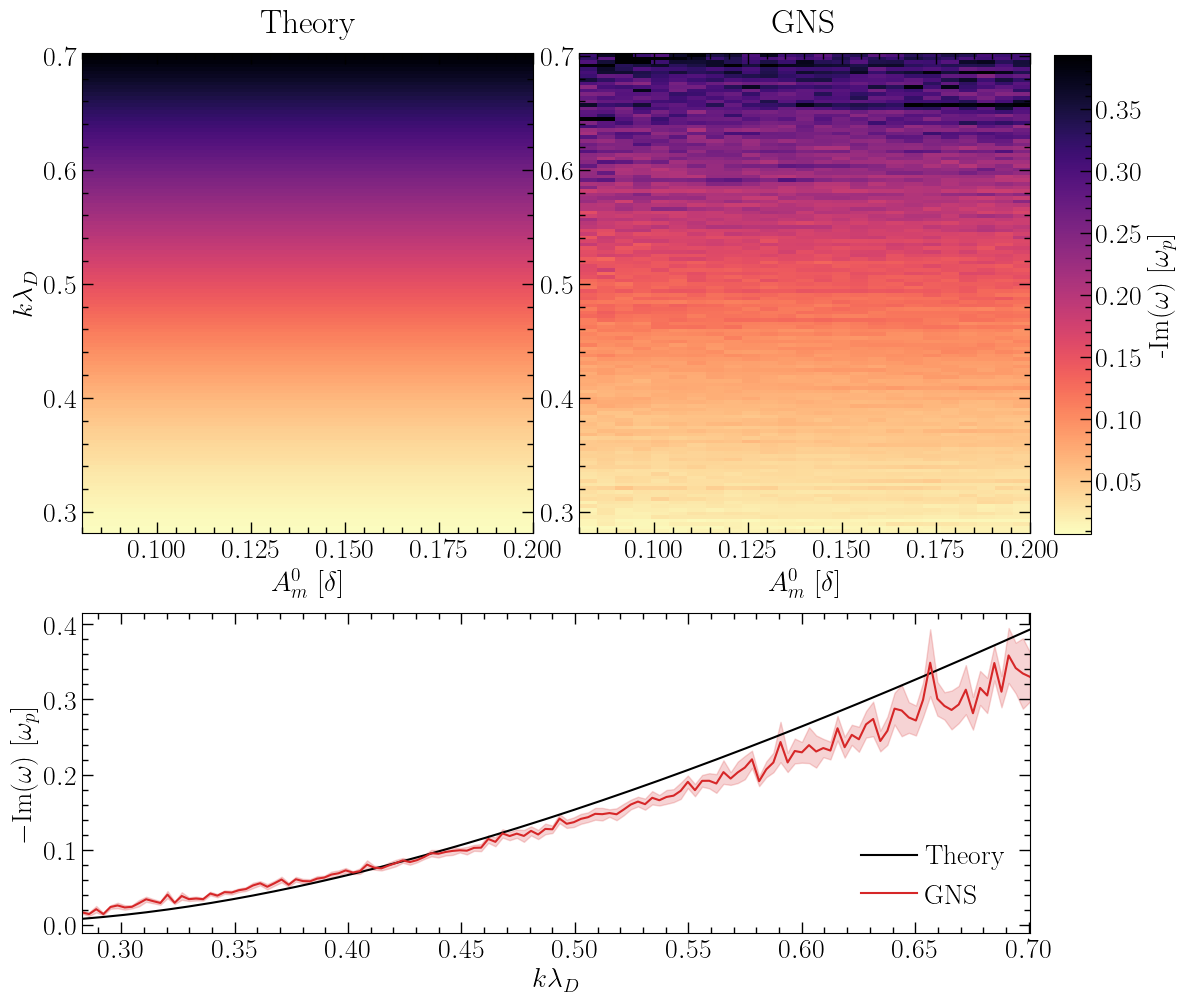

In [13]:
fig = plt.figure(figsize=(12, 10))

gs = gridspec.GridSpec(2, 1, figure=fig, 
                       height_ratios=(0.6, 0.4), 
                       wspace=0.1, hspace=0.2,
                       top=0.95, bottom=0.07, left=0.08, right=0.87)

gs_im = gridspec.GridSpecFromSubplotSpec(1, 2,
                                         height_ratios=(1,), width_ratios=(1,1), 
                                         wspace=0.1, hspace=0.02,
                                         subplot_spec=gs[0])

    
gs_line = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1])

ax = [None, None]
ax[0] = fig.add_subplot(gs_im[0])
ax[1] = fig.add_subplot(gs_im[1])

k = np.array([get_mode_info(m, n_sheets=n_sheets, v_th=v_th)['k'] * v_th
              for m in MODES if len(W_M_Teor[m]) > 0])

k_min = k[0]
k_max = k[-1]

aux_t = -np.array([np.array(Gamma_M_Teor[m]) for m in MODES if len(Gamma_M_Teor[m]) > 0])
im1 = ax[0].imshow(aux_t, aspect='auto', origin='lower', cmap='magma_r',
                   extent=[RD[0], RD[-1], k_min - np.pi/n_sheets*v_th, k_max + np.pi/n_sheets*v_th],
                )


aux = -np.array([np.array(Gamma_M_Am[m]) for m in MODES if len(Gamma_M_Teor[m]) > 0])
im2 = ax[1].imshow(aux, 
                  vmin=np.min(aux_t),
                  vmax=np.max(aux_t),
                   cmap='magma_r',
                  aspect='auto', origin='lower',
                  extent=[RD[0], RD[-1], k_min - np.pi/n_sheets*v_th, k_max + np.pi/n_sheets*v_th],
                 )
    

cbaxes = inset_axes(ax[-1], width="5%", height="100%", 
                    loc='lower right',
                    bbox_to_anchor=(0.02, k_min - 0.014, 0.2, k_max - k_min + 0.002),
                    bbox_transform=ax[-1].transData,
                   )
cbar = fig.colorbar(im2, cax=cbaxes,  orientation='vertical', label='-$\mathrm{Im}(\omega)$ [$\omega_p$]')


plt.setp(ax, xlabel='$A^0_m$ $[\delta]$')
ax[0].set_ylabel('$k\lambda_D$')
ax[0].set_title('Theory', pad=15)
ax[1].set_title('GNS', pad=15)

ax_line = fig.add_subplot(gs_line[0])

ax_line.plot(k, np.mean(aux_t, axis=1), color='k', label='Theory')
ax_line.plot(k, np.mean(aux, axis=1), color='tab:red', label='GNS')
ax_line.fill_between(k, 
                 np.mean(aux, axis=1)-np.std(aux, axis=1), 
                 np.mean(aux, axis=1)+np.std(aux, axis=1),
                 color='tab:red', alpha=0.2)
                 
ax_line.set_ylabel('$-\mathrm{Im}(\omega)$ [$\omega_p$]')
ax_line.set_xlabel('$k\lambda_D$')
ax_line.legend(loc='lower right')
ax_line.set_xlim(k[0],k[-1])
plt.savefig('../img/ld_w_im.pdf')
plt.show()

### Angular frequency - Re($\omega$)

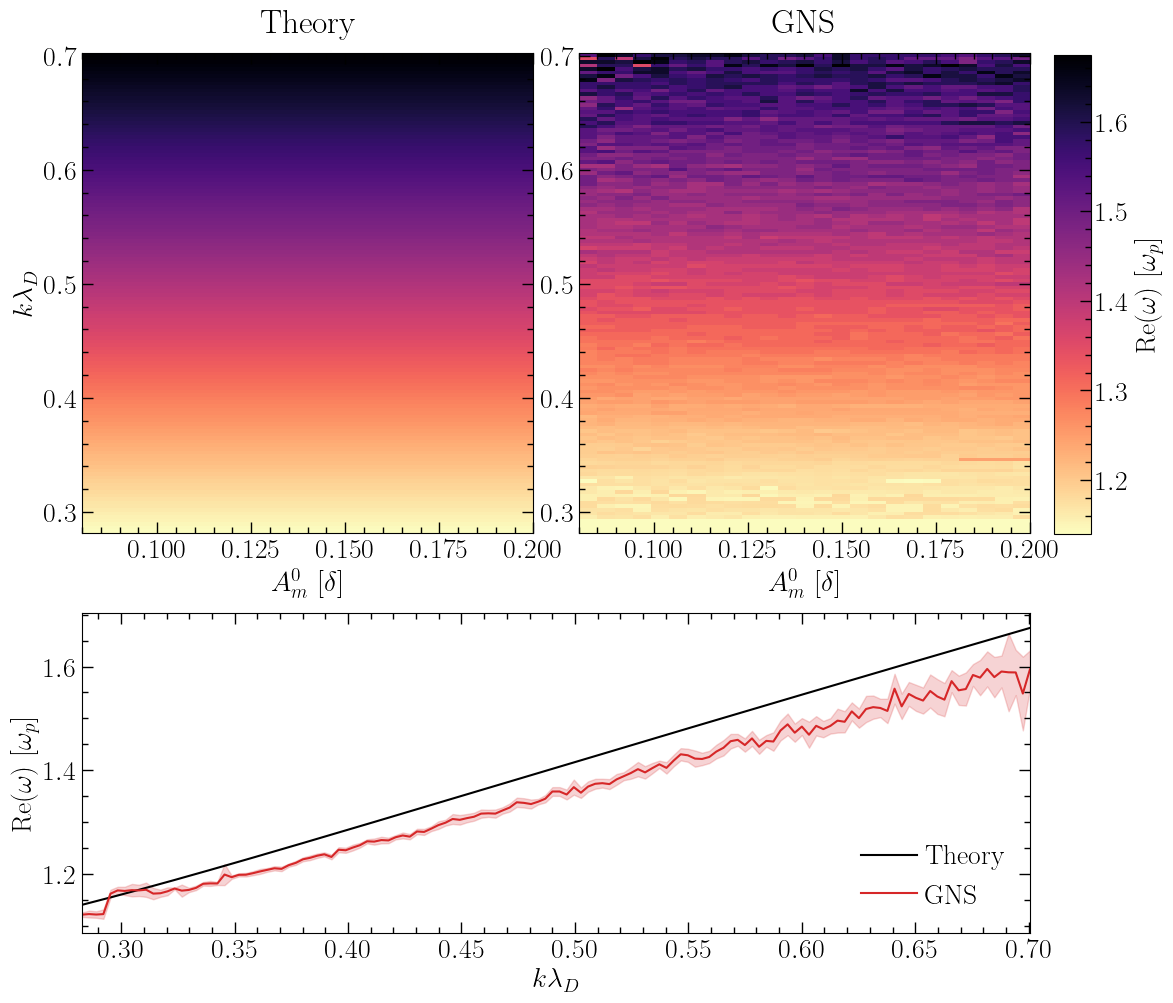

In [14]:
fig = plt.figure(figsize=(12, 10))

gs = gridspec.GridSpec(2, 1, figure=fig, 
                       height_ratios=(0.6, 0.4), 
                       wspace=0.1, hspace=0.2,
                       top=0.95, bottom=0.07, left=0.08, right=0.87)

gs_im = gridspec.GridSpecFromSubplotSpec(1, 2,
                                         height_ratios=(1,), width_ratios=(1,1), 
                                         wspace=0.1, hspace=0.02,
                                         subplot_spec=gs[0])

    
gs_line = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1])

ax = [None, None]
ax[0] = fig.add_subplot(gs_im[0])
ax[1] = fig.add_subplot(gs_im[1])

k = np.array([get_mode_info(m, n_sheets=n_sheets, v_th=v_th)['k'] * v_th
              for m in MODES if len(W_M_Teor[m]) > 0])

k_min = k[0]
k_max = k[-1]

aux_t = np.array([np.array(W_M_Teor[m]) for m in MODES if len(W_M_Teor[m]) > 0])
im1 = ax[0].imshow(aux_t, 
                   aspect='auto', 
                   origin='lower',
                   cmap='magma_r',
                   extent=[RD[0], RD[-1], k_min - np.pi/n_sheets*v_th, k_max + np.pi/n_sheets*v_th],
                  )


aux = np.array([np.array(W_M_Am[m]) for m in MODES if len(W_M_Teor[m]) > 0])
im2 = ax[1].imshow(aux, 
                   vmin=np.min(aux_t),
                   vmax=np.max(aux_t),
                   cmap='magma_r',
                   aspect='auto', origin='lower',
                   extent=[RD[0], RD[-1], k_min - np.pi/n_sheets*v_th, k_max + np.pi/n_sheets*v_th],
    #               interpolation='bilinear',
                  )
    

cbaxes = inset_axes(ax[-1], width="5%", height="100%", 
                    loc='lower right',
                    bbox_to_anchor=(0.02, k_min - 0.014, 0.2, k_max - k_min + 0.002),
                    bbox_transform=ax[-1].transData,
                   )

cbar = fig.colorbar(im2, cax=cbaxes,  orientation='vertical', label='$\mathrm{Re}(\omega)$ [$\omega_p$]')


plt.setp(ax, xlabel='$A^0_m$ $[\delta]$')
ax[0].set_ylabel('$k\lambda_D$')
ax[0].set_title('Theory', pad=15)
ax[1].set_title('GNS', pad=15)

ax_line = fig.add_subplot(gs_line[0])

ax_line.plot(k, np.mean(aux_t, axis=1), color='k', label='Theory')
ax_line.plot(k, np.mean(aux, axis=1), color='tab:red', label='GNS')
ax_line.fill_between(k, 
                 np.mean(aux, axis=1)-np.std(aux, axis=1), 
                 np.mean(aux, axis=1)+np.std(aux, axis=1),
                 color='tab:red', alpha=0.2)

ax_line.set_ylabel('$\mathrm{Re}(\omega)$ [$\omega_p$]')
ax_line.set_xlabel('$k\lambda_D$')
ax_line.legend(loc='lower right')
ax_line.set_xlim(k[0],k[-1])
plt.savefig('../img/ld_w_real.pdf')
plt.show()